In [49]:
from utils.vib_dataset import V2S_dataset
import matplotlib.pyplot as plt
import soundfile as sf
from tqdm import tqdm
import torch
import os
import IPython
import matplotlib.patches as mpatches
from matplotlib import rc
rc('text', usetex=False)
plt.rcParams.update({'font.size': 20})

def visualization_spec(audios):
    fig, axs = plt.subplots(len(audios), 2, figsize=(8, 6))
    for i in range(len(audios)):
        audio = audios[i]
        axs[i, 0].plot(audio, label='Audio Signal')
        axs[i, 1].specgram(audio, Fs=16000, NFFT=256, noverlap=128)
    plt.tight_layout()
    plt.show()
dataset = V2S_dataset()

In [ ]:
scores = []
predictor = torch.hub.load("tarepan/SpeechMOS:v1.2.0", "utmos22_strong", trust_repo=True)
for i, data in tqdm(enumerate(dataset), total=len(dataset)):
        audio = data['audio'][None, :]
        audio = torch.from_numpy(audio).float()
        score = predictor(audio, 16000)
        scores.append(score.item())

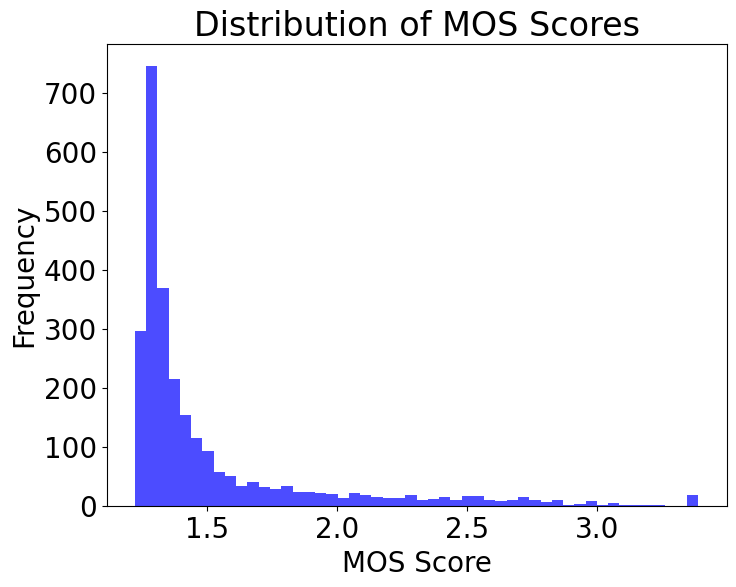

In [51]:
fig = plt.figure(figsize=(8, 6))
plt.hist(scores, bins=50, color='blue', alpha=0.7)
plt.xlabel('MOS Score')
plt.ylabel('Frequency')
plt.title('Distribution of MOS Scores')
plt.savefig('resources/mos_distribution.pdf')

In [4]:
from models import SNR_Estimator_LSTM, SNR_Estimator_CNN
import json
json_path = 'config/snr_estimator.json'
config = json.load(open(json_path, 'r'))
device = 'cuda:1'
model = SNR_Estimator_CNN(**config["model"]["params"])
ckpt_path = 'runs/snr_estimator/cnn/checkpoints/epoch=4-step=47940.ckpt'
ckpt = torch.load(ckpt_path, map_location='cpu')
ckpt['state_dict'] = {k.replace('model.', ''): v for k, v in ckpt['state_dict'].items()}
model.load_state_dict(ckpt['state_dict'])
model.to(device)
model.eval()
print(f"Loading checkpoint from {ckpt_path}")

snrs = []
with torch.no_grad():
    for i, data in tqdm(enumerate(dataset), total=len(dataset)):
        audio = data['audio'][None, :]; vibration = data['vibration'][None, :]
        audio = torch.from_numpy(audio).to(device); vibration = torch.from_numpy(vibration).to(device)
        output = model(audio, vibration)
        snr = (output.item() * (20 - (-20)) + (-20))
        snrs.append(snr)

Loading checkpoint from runs/snr_estimator/cnn/checkpoints/epoch=4-step=47940.ckpt


100%|██████████| 2648/2648 [00:32<00:00, 81.62it/s]


In [ ]:
# pick pairs of snr that have more than 5dB difference, pick 100 pairs
import IPython.display
import numpy as np
import IPython

snr_pairs_diff = np.abs(np.array(snrs)[:, None] - np.array(snrs)[None, :])
diff_range = (5, 6)
# find indices where the difference is within the range
indices = np.where((snr_pairs_diff >= diff_range[0]) & (snr_pairs_diff <= diff_range[1]))
# randomly select 100 pairs from the indices
np.random.seed(42)  # for reproducibility
random_indices = np.random.choice(len(indices[0]), size=20, replace=False)
user_feedback = []
for indice in random_indices:
    indice_x, indice_y = indices[0][indice], indices[1][indice]
    snr1 = snrs[indice_x]; snr2 = snrs[indice_y]; snr_diff = snr_pairs_diff[indice_x, indice_y]
    audio1 = dataset[indice_x]['audio']
    audio2 = dataset[indice_y]['audio']

    # visualization_spec([audio1, audio2])
    sf.write('temp.wav', audio1, 16000)
    IPython.display.display(IPython.display.Audio('temp.wav'))
    sf.write('temp.wav', audio2, 16000)
    IPython.display.display(IPython.display.Audio('temp.wav'))
    os.remove('temp.wav')

    # add an input to get the user-feedback
    user_input = input(f"which audio is better? (1 or 2), 0 refers to invalid: ")
    if user_input == '1':
        print(f"Audio 1 is better with SNR: {snr1:.2f} dB")
    elif user_input == '2':
        print(f"Audio 2 is better with SNR: {snr2:.2f} dB")
    else:
        print("Invalid input, please enter 1 or 2.")
    # clean the output figure
    plt.clf()
    plt.close('all')
    IPython.display.clear_output()
    user_feedback.append((snr1, snr2, user_input))
# Save user feedback to a file
with open('user_feedback.json', 'w') as f:
    json.dump(user_feedback, f, indent=4)